# Binaural demo

Example binaural STRF model fit for a single cell.

## Initialize python environment

In [1]:
import logging
import pickle
from pathlib import Path
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nems0.analysis.api
import nems0.initializers
import nems0.preprocessing as preproc
import nems0.uri
from nems0 import db
from nems0 import xforms
from nems0 import recording
from nems0.fitters.api import scipy_minimize
from nems0.signal import RasterizedSignal
import nems0.epoch as ep
from nems.tools import json
from nems.models import LN
from nems_lbhb.projects.spatial.models import LN_Tiled_STRF

from nems.visualization.model import plot_nl
from nems.metrics import correlation

from nems_lbhb.xform_wrappers import generate_recording_uri
from nems_lbhb.projects.freemoving.free_tools import stim_filt_hrtf, compute_d_theta, \
    free_scatter_sum, dlc2dist

log = logging.getLogger(__name__)

## Select site and load data

In [3]:
# testing binaural NAT with various model architectures.
batch=338
siteids,cellids=db.get_batch_sites(batch)

siteid="PRN031a"
siteid="PRN014b"
siteid="CLT013a"
siteid="SLJ021a"
siteid="PRN021a"
siteid="CLT041c"

# uncomment one of these lines to choose a different stimulus representation
#loadkey = "gtgram.fs100.ch18.bin10"   # binaural + HRTF
loadkey = "gtgram.fs100.ch18.bin100"   # binaural allocentric
#loadkey = "gtgram.fs100.ch18.mono"    # monoaural + noise to balance estimation noise

# architecture can be "full" or "tiled"
architecture = "tiled"
#architecture = "full"
#architecture = "fullpop"

use_hrtf=True  # if not, allocentric
time_lags = 20
rank = 6

recording_uri = generate_recording_uri(cellid=siteid, batch=batch, loadkey=loadkey)
rec = recording.load_recording(recording_uri)

if use_hrtf:
    # impose HRTF on stimulI
    rec=stim_filt_hrtf(rec)['rec']

print(f"Site {siteid} has {rec['resp'].shape[0]} cells")

[nems_lbhb.xform_wrappers INFO] loader=gtgram.fs100.ch18.bin100
[nems_lbhb.baphy_io INFO] loader=gtgram.fs100.ch18.bin100
[nems_lbhb.baphy_experiment INFO] {'rasterfs': 100, 'stimfmt': 'gtgram', 'chancount': 18, 'pertrial': 0, 'includeprestim': 1, 'pupil': 0, 'rem': 0, 'raw': 0, 'mua': 0, 'resp': 1, 'stim': 1, 'runclass': None, 'rawid': None, 'facemap': False, 'facepca': False, 'channels': 18, 'binaural': 100.0, 'binsplit': False, 'batch': 338, 'version': 'BAPHYExperiment.3', 'mfiles': ['/auto/data/daq/Clathrus/CLT041/CLT041c12_p_BNT'], 'cell_list': ['CLT041c-002-1', 'CLT041c-002-2', 'CLT041c-011-1', 'CLT041c-019-1', 'CLT041c-026-1', 'CLT041c-026-2', 'CLT041c-029-1', 'CLT041c-031-1', 'CLT041c-033-1', 'CLT041c-037-1', 'CLT041c-037-2', 'CLT041c-038-1', 'CLT041c-038-2', 'CLT041c-040-1', 'CLT041c-042-1', 'CLT041c-045-1', 'CLT041c-046-1', 'CLT041c-049-1', 'CLT041c-050-1', 'CLT041c-051-1', 'CLT041c-052-1', 'CLT041c-052-2', 'CLT041c-052-3', 'CLT041c-053-1', 'CLT041c-054-1', 'CLT041c-054-2', '

Site CLT041c has 29 cells


## Initialize model and fit

In [4]:
ctx = {'rec': rec}
ctx.update(xforms.normalize_sig(sig='resp', norm_method='minmax', **ctx))
ctx.update(xforms.normalize_sig(sig='stim', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.split_by_occurrence_counts(epoch_regex='^STIM', **ctx))
ctx.update(xforms.average_away_stim_occurrences(epoch_regex='^STIM', **ctx))

epochs = ctx['est']['resp'].epochs
stim_epochs = ep.epoch_names_matching(epochs, "^STIM_")
mono_epochs = [e for e in stim_epochs if e.startswith("STIM_NULL") | e.endswith("NULL:2")]
bin_epochs = [e for e in stim_epochs if (e.startswith("STIM_NULL") is False) & (e.endswith("NULL:2") is False)]
val_epochs = ep.epoch_names_matching(ctx['val']['resp'].epochs, "^STIM_")

print(f"N stimuli: bin/mono/total: {len(bin_epochs)}/{len(mono_epochs)}/{len(stim_epochs)}")

#
# Extract data for a single neuron
#

# pick a cell
if architecture.endswith("pop"):
    cid=np.arange(ctx['est']['resp'].shape[0])
    cellid = siteid
else:
    cid=[18]  # number 19 is "nice"
    cellid = ctx['est']['resp'].chans[cid[0]]

X_ = ctx['est']['stim'].extract_epochs(stim_epochs)
Y_ = ctx['est']['resp'].extract_epochs(stim_epochs)
# convert to matrix
X_est = np.stack([X_[k][0,:,:].T for k in X_.keys()], axis=0)
Y_est = np.stack([Y_[k][0,cid,:].T for k in X_.keys()], axis=0)

X_ = ctx['val']['stim'].extract_epochs(val_epochs)
Y_ = ctx['val']['resp'].extract_epochs(val_epochs)
# convert to matrix
X_val = np.stack([X_[k][0,:,:].T for k in X_.keys()], axis=0)
Y_val = np.stack([Y_[k][0,cid,:].T for k in X_.keys()], axis=0)

print(X_est.shape, Y_est.shape, X_val.shape, Y_val.shape)

# do the fit

input_channels = X_est.shape[2]
output_channels = Y_est.shape[2]

modelname = f"{cellid}_{loadkey}_{architecture}_rank{rank}"
if architecture == 'full':
    strf_base = LN.LN_STRF(time_lags, input_channels, rank=rank, gaussian=False,
                           fs=rec['resp'].fs, regularizer='l2:4', name=modelname)
elif architecture == 'fullpop':
    strf_base = LN.LN_pop(time_lags, input_channels, output_channels,
                          rank=rank, gaussian=False,
                          fs=rec['resp'].fs, name=modelname)
elif architecture == 'tiled':
    input_channels=int(input_channels/2)
    strf_base = LN_Tiled_STRF(time_lags, input_channels, rank=rank, gaussian=False,
                              fs=rec['resp'].fs, name=modelname)
else:
    raise ValueError(f"Unknown architecture {architecture}")

strf_base.meta['cellid']=cellid
strf_base.meta['loader']=loadkey

strf = strf_base.fit_LBHB(X_est, Y_est)

# use STRF to predict validation response and measure accuracy with correlation function
predict = strf.predict(X_val, batch_size=None)
predict.shape, Y_val.shape
r=correlation(predict, Y_val)
print(f"prediction correlation={np.round(r,2)}")
strf.meta['r_test']=np.array([[r]])

[nems0.xforms INFO] xforms.normalize_sig(minmax): resp b=0.0, g=3.8620689655172415, dlog(..., -None)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim b=0.0, g=2.512647328447742, dlog(..., -1)


N stimuli: bin/mono/total: 90/90/180


[nems.models.LN INFO] Fit stage 1: w/o static output nonlinearity


(180, 2200, 36) (180, 2200, 1) (6, 2200, 36) (6, 2200, 1)


2024-02-02 15:12:54.889173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-02 15:12:54.893200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-02 15:12:54.893294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-02 15:12:54.893557: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1 Physical GPUs, 1 Logical GPUs


2024-02-02 15:12:56.560777: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2024-02-02 15:12:56.982872: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-02 15:12:56.983507: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-02 15:12:56.983514: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-02-02 15:12:56.984051: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-02 15:12:56.984089: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
[nems.backends.tf.backend INFO] Init loss: 1.602, tol: 0.001, b

Restoring model weights from the end of the best epoch: 168.
Epoch 00318: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[nems.backends.tf.backend INFO] Init loss: 0.939, tol: 0.0001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/8000 - loss: 0.9264
[nems.backends.tf.backend INFO] Epoch 0050/8000 - loss: 0.8600
[nems.backends.tf.backend INFO] Epoch 0100/8000 - loss: 0.8578
[nems.backends.tf.backend INFO] Epoch 0150/8000 - loss: 0.8573
[nems.backends.tf.backend INFO] Epoch 0200/8000 - loss: 0.8570
[nems.backends.tf.backend INFO] Epoch 0250/8000 - loss: 0.8569
[nems.backends.tf.backend INFO] Epoch 0300/8000 - loss: 0.8568
[nems.backends.tf.backend INFO] Epoch 0350/8000 - loss: 0.8568
[nems.backends.tf.backend INFO] Epoch 0400/8000 - loss: 0.8567
[nems.backends.tf.backend INFO] Epoch 0450/8000 - loss: 0.8567
[nems.backends.tf.backend INFO] Epoch 0500/8000 - los

Restoring model weights from the end of the best epoch: 533.
Epoch 00683: early stopping
prediction correlation=0.55


## Plot results

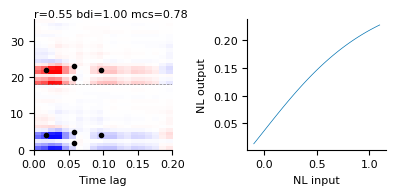

In [5]:
strf.plot_strf();

In [6]:
strf.get_tuning()

{'cellid': 'CLT041c-050-1',
 'cbf': 496.0,
 'clat': 0.0175,
 'cofflat': 0.0975,
 'cbfidx': 3.5,
 'clatbin': 1.75,
 'cofflatbin': 9.75,
 'cbfpos': False,
 'cbloidx': 1.25,
 'cbhiidx': 4.5,
 'cbw': 1.0833333333333333,
 'cstepsize': 0.3333333333333333,
 'ibf': 496.0,
 'ilat': 0.0175,
 'iofflat': 0.0975,
 'ibfidx': 3.5,
 'ilatbin': 1.75,
 'iofflatbin': 9.75,
 'ibfpos': True,
 'ibloidx': 1.25,
 'ibhiidx': 4.5,
 'ibw': 1.0833333333333333,
 'istepsize': 0.3333333333333333,
 'bdi': 1.0000001,
 'mcs': 0.7793592,
 'ipsi_offset': 18}

## save/load

In [29]:
# save
json.save_model(strf, f'/tmp/modelspec_{siteid}_strf.json')

In [32]:
# load
reloaded_strf = json.load_model(f'/tmp/modelspec_{siteid}_strf.json')
type(reloaded)

INITIALIZING AS nems.models.LN.LN_STRF


nems.models.LN.LN_STRF

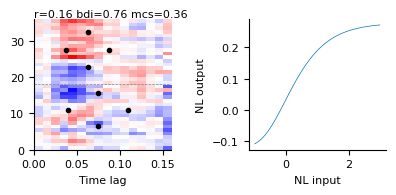

In [6]:
reloaded_strf.plot_strf();

# Load some models fit on exacloud

First load single model, look at tuning

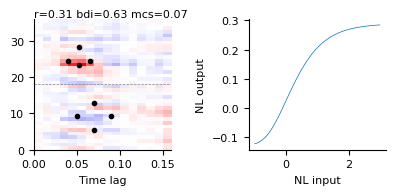

In [8]:
cellid = 'LMD004a-A-221-1'
savefile =f'/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_STRF/{cellid}.json'
reloaded_strf = json.load_model(savefile)
reloaded_strf.plot_strf();

In [14]:
d=reloaded_strf.get_tuning()
print('contra bf:', d['cbf'])
print('ipsi bf:', d['ibf'])
print('binaural difference index [np.std(contra-ipsi) / (contra.std()+ipsi.std())]:', d['bdi'])
print('frac ipsi excitatory [ipsi.mean() / np.abs(ipsi).mean()]:', d['mcs'])


contra bf: 1936.0
ipsi bf: 949.0
binaural difference index [np.std(contra-ipsi) / (contra.std()+ipsi.std())]: 0.634948139232631
frac ipsi excitatory [ipsi.mean() / np.abs(ipsi).mean()]: 0.07425008129075457


## Multiple cells

Plot STRFs in a single figure, compare LN_STRF and LN_Tiled_STRF

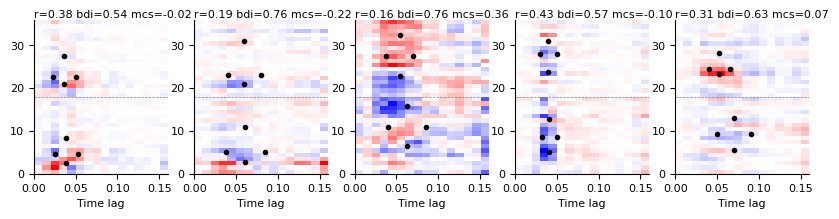

In [15]:
celllist = ['LMD004a-A-321-1', 'LMD004a-A-295-1', 'LMD004a-A-201-1', 'LMD004a-A-193-1', 'LMD004a-A-221-1']

f,axs=plt.subplots(1,len(celllist), figsize=(len(celllist)*2,2));
for cellid,ax in zip(celllist,axs):
    savefile =f'/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_STRF/{cellid}.json'
    reloaded_strf = json.load_model(savefile)
    reloaded_strf.plot_strf(ax=ax)


/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_Tiled_STRF/LMD004a-A-321-1.json
/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_Tiled_STRF/LMD004a-A-295-1.json
/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_Tiled_STRF/LMD004a-A-201-1.json
/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_Tiled_STRF/LMD004a-A-193-1.json
/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_Tiled_STRF/LMD004a-A-221-1.json


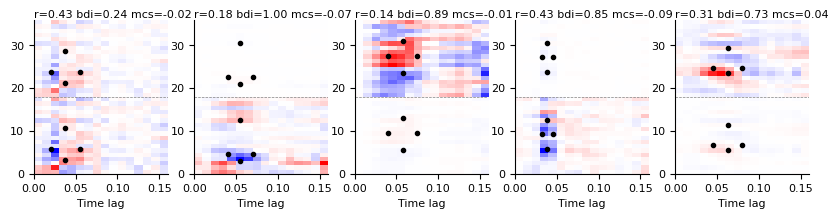

In [16]:
celllist = ['LMD004a-A-321-1', 'LMD004a-A-295-1', 'LMD004a-A-201-1', 'LMD004a-A-193-1', 'LMD004a-A-221-1']

f,axs=plt.subplots(1,len(celllist), figsize=(len(celllist)*2,2));
for cellid,ax in zip(celllist,axs):
    savefile =f'/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/LN_Tiled_STRF/{cellid}.json'    
    reloaded_strf = json.load_model(savefile)
    reloaded_strf.plot_strf(ax=ax)

In [5]:
reloaded_strf.get_tuning()

{'subclass': 'nems.models.LN.LN_STRF',
 'cellid': 'LMD004a-A-201-1',
 'loadkey': 'gtgram.fs100.ch18.bin6',
 'r_test': 0.163,
 'architecture': 'LN_STRF',
 'siteid': 'LMD004a',
 'batch': 338}

# Send jobs to Exacloud

In [37]:
import os
from nems_lbhb.exacloud import queue_exacloud_job
df = db.get_batch_cells(338)
cellids=df['cellid'].to_list()

In [43]:
queue_exacloud_job.enqueue_exacloud_script?

Signature:
queue_exacloud_job.enqueue_exacloud_script(
    script_path,
    parameter_string,
    user,
    executable_path='/home/users/davids/miniconda3/envs/nems/bin/python',
    linux_user='davids',
    priority=1,
    time_limit=14,
    reserve_gb=0,
    useGPU=False,
    high_mem=False,
    exclude=None,
    force_rerun=False,
)
Docstring:
Enqueues models similarly to nems0.db.enqueue_models, except on the Exacloud cluster at ACC.

:param script_path: Script to run.
:param parameter_string: string of parameter(s) to pass to script
:param user: LBHB username.
:param executable_path: Executable used to run script (default nems python)
:param linux_user: OHSU Username of one starting the job.
:param time_limit: Max hours the job will run for. Jobs will terminated if not complete by the end of the time limit.
:param reserve_gb: Max GB required for the job. Job will fail if memory use goes above this level.
:param useGPU: Whether or not to be GPU job.
:param high_mem: Whether or not G

In [41]:
df = db.get_batch_cells(338)
cellids=df['cellid'].to_list()
cellids=cellids

script = '/home/users/davids/nems_db/nems_lbhb/projects/spatial/fit_spatial_site.py'
stimfmt='monaural'
stimfmt='binaural_allocentric'
stimfmt='binaural_HRTF'

architecture="LN_Tiled_STRF"
for cellid in cellids:
    # figure out where the fit for this cell/stim/architecutre should be saved
    load_path=f"/auto/data/nems_db/results/338/gtgram.fs100.ch18.bin6/{architecture}/{cellid}.json"
    # check if that file exists
    if os.path.exists(load_path):
        pass
    else:
        # if doesn't exist, send this job to the queue
        parmstring=f"{cellid} {stimfmt} {architecture}"
        print(parmstring)
        queue_exacloud_job.enqueue_exacloud_script(script, parmstring, 'alexis')   

[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-014-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-018-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-021-2/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-022-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-025-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-027-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-028-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-031-3/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-034-2/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_jo

CLT011a-014-1 binaural_HRTF LN_Tiled_STRF
CLT011a-018-1 binaural_HRTF LN_Tiled_STRF
CLT011a-021-2 binaural_HRTF LN_Tiled_STRF
CLT011a-022-1 binaural_HRTF LN_Tiled_STRF
CLT011a-025-1 binaural_HRTF LN_Tiled_STRF
CLT011a-027-1 binaural_HRTF LN_Tiled_STRF
CLT011a-028-1 binaural_HRTF LN_Tiled_STRF
CLT011a-031-3 binaural_HRTF LN_Tiled_STRF
CLT011a-034-2 binaural_HRTF LN_Tiled_STRF
CLT011a-036-3 binaural_HRTF LN_Tiled_STRF
CLT011a-036-4 binaural_HRTF LN_Tiled_STRF
CLT011a-038-2 binaural_HRTF LN_Tiled_STRF
CLT011a-039-2 binaural_HRTF LN_Tiled_STRF
CLT011a-039-3 binaural_HRTF LN_Tiled_STRF
CLT011a-039-4 binaural_HRTF LN_Tiled_STRF
CLT011a-040-4 binaural_HRTF LN_Tiled_STRF
CLT011a-040-5 binaural_HRTF LN_Tiled_STRF
CLT011a-040-6 binaural_HRTF LN_Tiled_STRF
CLT011a-042-1 binaural_HRTF LN_Tiled_STRF
CLT011a-042-2 binaural_HRTF LN_Tiled_STRF
CLT011a-043-1 binaural_HRTF LN_Tiled_STRF
CLT011a-044-1 binaural_HRTF LN_Tiled_STRF
CLT011a-045-2 binaural_HRTF LN_Tiled_STRF
CLT011a-046-2 binaural_HRTF LN_Til

[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-055-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-055-2/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-058-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-058-2/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-061-1/binaural_HRTF/LN_Tiled_STRF
[nems_lbhb.exacloud.queue_exacloud_job INFO] Added exacloud job: CLT011a-063-1/binaural_HRTF/LN_Tiled_STRF


CLT011a-055-2 binaural_HRTF LN_Tiled_STRF
CLT011a-058-1 binaural_HRTF LN_Tiled_STRF
CLT011a-058-2 binaural_HRTF LN_Tiled_STRF
CLT011a-061-1 binaural_HRTF LN_Tiled_STRF
CLT011a-063-1 binaural_HRTF LN_Tiled_STRF


Load some data

In [28]:
# testing binaural NAT with various model architectures.
batch=338
siteid="CLT041c"

# uncomment one of these lines to choose a different stimulus representation
loadkey = "gtgram.fs100.ch18.bin6"   # binaural + HRTF
#loadkey = "gtgram.fs100.ch18.bin100"   # binaural allocentric
#loadkey = "gtgram.fs100.ch18.mono"    # monoaural + noise to balance estimation noise

recording_uri = generate_recording_uri(cellid=siteid, batch=batch, loadkey=loadkey)
rec = recording.load_recording(recording_uri)

print(f"Site {siteid} has {rec['resp'].shape[0]} cells")

[nems_lbhb.xform_wrappers INFO] loader=gtgram.fs100.ch18.bin6
[nems_lbhb.baphy_io INFO] loader=gtgram.fs100.ch18.bin6
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/338/CLT041c_217e1e64d6526e255bb6b2e6bca7784984d7d61a.tgz


Site CLT041c has 29 cells


Normalize stimulus and response to have min/max of 0/1

In [29]:
ctx = {'rec': rec}
ctx.update(xforms.normalize_sig(sig='resp', norm_method='minmax', **ctx))
ctx.update(xforms.normalize_sig(sig='stim', norm_method='minmax', **ctx))
ctx.update(xforms.split_by_occurrence_counts(epoch_regex='^STIM', **ctx))
ctx.update(xforms.average_away_stim_occurrences(epoch_regex='^STIM', **ctx))


[nems0.xforms INFO] xforms.normalize_sig(minmax): resp b=0.0, g=3.8620689655172415, dlog(..., -None)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim b=0.0, g=0.7392688939054671, dlog(..., -None)


Find binaural and monoaural stimulus epochs

In [30]:
epochs = ctx['est']['resp'].epochs
stim_epochs = ep.epoch_names_matching(epochs, "^STIM_")
mono_epochs = [e for e in stim_epochs if e.startswith("STIM_NULL") | e.endswith("NULL:2")]
bin_epochs = [e for e in stim_epochs if (e.startswith("STIM_NULL") is False) & (e.endswith("NULL:2") is False)]
val_epochs = ep.epoch_names_matching(ctx['val']['resp'].epochs, "^STIM_")

print(f"N stimuli: bin/mono/total: {len(bin_epochs)}/{len(mono_epochs)}/{len(stim_epochs)}")

N stimuli: bin/mono/total: 90/90/180


# Extract data for a single neuron

Extract stim/resp data in a format that works with NEMS models. Take data from a single cell for now.

In [31]:
# pick a cell
cid=19  # number 19 is "nice"
cellid = ctx['est']['resp'].chans[cid]


X_ = ctx['est']['stim'].extract_epochs(stim_epochs)
Y_ = ctx['est']['resp'].extract_epochs(stim_epochs)
# convert to matrix
X_est = np.stack([X_[k][0,:,:].T for k in X_.keys()], axis=0)
Y_est = np.stack([Y_[k][0,[cid],:].T for k in X_.keys()], axis=0)

X_ = ctx['val']['stim'].extract_epochs(val_epochs)
Y_ = ctx['val']['resp'].extract_epochs(val_epochs)
# convert to matrix
X_val = np.stack([X_[k][0,:,:].T for k in X_.keys()], axis=0)
Y_val = np.stack([Y_[k][0,[cid],:].T for k in X_.keys()], axis=0)

X_est.shape, Y_est.shape, X_val.shape, Y_val.shape

((180, 2200, 36), (180, 2200, 1), (6, 2200, 36), (6, 2200, 1))

Plot to make sure the cell is giving reasonable responses

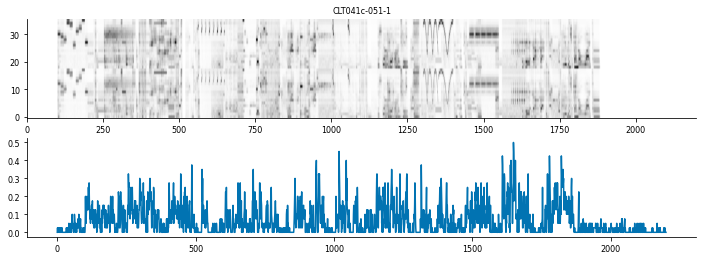

In [32]:
f,ax = plt.subplots(2,1,figsize=(12,4))
stimidx=0
ax[0].imshow(X_val[stimidx, : :].T, aspect='auto', cmap='gray_r', origin='lower')
ax[1].plot(Y_val[0,:,0]);
ax[0].set_title(cellid);

# Fit LN STRF

In [33]:
input_channels = X_est.shape[2]
time_lags = 16
rank = 5
strf_base = LN.LN_STRF(time_lags, input_channels, rank=rank, gaussian=False, fs=rec['resp'].fs)
strf = strf_base.fit_LBHB(X_est, Y_est)

[nems.models.LN INFO] Fit stage 1: w/o static output nonlinearity
[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 2200, 36)]        0         
[nems.backends.tf.backend INFO]  WeightChannels (WeightChann  (None, 2200, 5)          180       
[nems.backends.tf.backend INFO]  elsTF)                                                          
[nems.backends.tf.backend INFO]  FiniteImpulseResponse (Fini  (None, 2200, 1)          80        
[nems.backends.tf.backend INFO]  teImpulseResponseTF)                                            
[nems.backends.tf.backend INFO]  Dou

6/6 [==============================] - 0s 6ms/step - loss: 0.9612


[nems.backends.tf.backend INFO] Init loss: 0.961, tol: 0.001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/3000 - loss: 0.9183
[nems.backends.tf.backend INFO] Epoch 0050/3000 - loss: 0.8398
[nems.backends.tf.backend INFO] Epoch 0100/3000 - loss: 0.8386
[nems.backends.tf.backend INFO] Epoch 0150/3000 - loss: 0.8383
[nems.backends.tf.backend INFO] Epoch 0200/3000 - loss: 0.8381
[nems.backends.tf.backend INFO] Epoch 0250/3000 - loss: 0.8380
[nems.backends.tf.backend INFO] Final loss: 0.8380
[nems.models.LN INFO] Fit stage 2: with static output nonlinearity


Restoring model weights from the end of the best epoch: 102.
Epoch 00252: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[nems.backends.tf.backend INFO] Init loss: 1.375, tol: 0.0001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/8000 - loss: 1.3486
[nems.backends.tf.backend INFO] Epoch 0050/8000 - loss: 0.8502
[nems.backends.tf.backend INFO] Epoch 0100/8000 - loss: 0.8361
[nems.backends.tf.backend INFO] Epoch 0150/8000 - loss: 0.8334
[nems.backends.tf.backend INFO] Epoch 0200/8000 - loss: 0.8321
[nems.backends.tf.backend INFO] Epoch 0250/8000 - loss: 0.8313
[nems.backends.tf.backend INFO] Epoch 0300/8000 - loss: 0.8308
[nems.backends.tf.backend INFO] Epoch 0350/8000 - loss: 0.8303
[nems.backends.tf.backend INFO] Epoch 0400/8000 - loss: 0.8300
[nems.backends.tf.backend INFO] Epoch 0450/8000 - loss: 0.8298
[nems.backends.tf.backend INFO] Epoch 0500/8000 - los

Restoring model weights from the end of the best epoch: 938.
Epoch 01088: early stopping


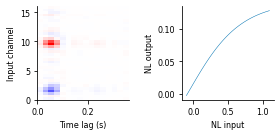

In [34]:
# built-in function for displaying fit result
strf.plot_strf()

In [35]:
# use STRF to predict validation response and measure accuracy with correlation function
predict = strf.predict(X_val, batch_size=None)
predict.shape, Y_val.shape
r=correlation(predict, Y_val)
print(f"prediction correlation={r:.3f}")

prediction correlation=0.599


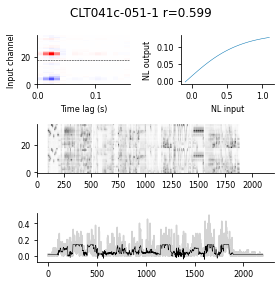

In [36]:
f = plt.figure(figsize=(4,4))
ax = f.add_subplot(3,2,1)

strf1 = strf.get_strf()
channels_out = strf1.shape[-1]

mm = np.nanmax(abs(strf1))
if strf.fs is not None:
    extent = [0, strf1.shape[1] / strf.fs, 0, strf1.shape[0]]
else:
    extent = [0, strf1.shape[1], 0, strf1.shape[0]]
ax.imshow(strf1, aspect='auto', interpolation='none', origin='lower',
             cmap='bwr', vmin=-mm, vmax=mm, extent=extent)
ax.axhline(y=17.5, ls='--', color='black', lw=0.5)

if strf.fs is not None:
    ax.set_xlabel('Time lag (s)')
else:
    ax.set_xlabel('Time lag (bins)')
ax.set_ylabel('Input channel')

ax2 = f.add_subplot(3,2,2)

ymin, ymax = strf.out_range[0][0], strf.out_range[1][0]
plot_nl(strf.layers[-1], range=[ymin, ymax], ax=ax2)

stimidx=0 # can be 0... 5

ax3 = f.add_subplot(3,1,2)
ax4 = f.add_subplot(3,1,3)

ax3.imshow(X_val[stimidx, : :].T, aspect='auto', cmap='gray_r', origin='lower')
ax4.plot(Y_val[stimidx, :, :], color='lightgray')
ax4.plot(predict[stimidx, :, :], color='black', lw=0.5)

f.suptitle(f"{cellid} r={r:.3f}")
plt.tight_layout()
f.savefig(f'/tmp/{cellid}_strf.jpg')

# Tiled binaural model

In [37]:
input_channels = int(X_est.shape[2]/2)
time_lags = 16
rank = 5
strf_base = LN_Tiled_STRF(time_lags, input_channels, rank=rank, gaussian=False, fs=rec['resp'].fs)
strf_tiled = strf_base.fit_LBHB(X_est, Y_est)

[nems_lbhb.projects.spatial.models INFO] Fit stage 1: w/o static output nonlinearity
[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 2200, 36)]        0         
[nems.backends.tf.backend INFO]  WeightChannelsMulti (Weight  (None, 2200, 5, 2)       90        
[nems.backends.tf.backend INFO]  ChannelsMultiTF)                                                
[nems.backends.tf.backend INFO]  FiniteImpulseResponse (Fini  (None, 2200, 2)          80        
[nems.backends.tf.backend INFO]  teImpulseResponseTF)                                            
[nems.backends.tf

6/6 [==============================] - 0s 6ms/step - loss: 2.0904


[nems.backends.tf.backend INFO] Init loss: 2.090, tol: 0.001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/3000 - loss: 1.7610
[nems.backends.tf.backend INFO] Epoch 0050/3000 - loss: 0.8431
[nems.backends.tf.backend INFO] Epoch 0100/3000 - loss: 0.8420
[nems.backends.tf.backend INFO] Epoch 0150/3000 - loss: 0.8416
[nems.backends.tf.backend INFO] Epoch 0200/3000 - loss: 0.8414
[nems.backends.tf.backend INFO] Epoch 0250/3000 - loss: 0.8413
[nems.backends.tf.backend INFO] Final loss: 0.8412
[nems_lbhb.projects.spatial.models INFO] Fit stage 2: with static output nonlinearity


Restoring model weights from the end of the best epoch: 102.
Epoch 00252: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[nems.backends.tf.backend INFO] Init loss: 1.567, tol: 0.0001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/8000 - loss: 1.5308
[nems.backends.tf.backend INFO] Epoch 0050/8000 - loss: 0.8421
[nems.backends.tf.backend INFO] Epoch 0100/8000 - loss: 0.8415
[nems.backends.tf.backend INFO] Epoch 0150/8000 - loss: 0.8412
[nems.backends.tf.backend INFO] Epoch 0200/8000 - loss: 0.8410
[nems.backends.tf.backend INFO] Epoch 0250/8000 - loss: 0.8408
[nems.backends.tf.backend INFO] Epoch 0300/8000 - loss: 0.8407
[nems.backends.tf.backend INFO] Epoch 0350/8000 - loss: 0.8405
[nems.backends.tf.backend INFO] Epoch 0400/8000 - loss: 0.8404
[nems.backends.tf.backend INFO] Epoch 0450/8000 - loss: 0.8403
[nems.backends.tf.backend INFO] Epoch 0500/8000 - los

Restoring model weights from the end of the best epoch: 1736.
Epoch 01886: early stopping


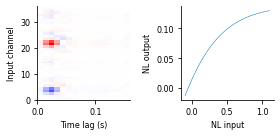

In [38]:
# built-in function for displaying fit result
strf_tiled.plot_strf()

In [39]:
# use STRF to predict validation response and measure accuracy with correlation function

predict = strf_tiled.predict(X_val, batch_size=None)
predict.shape, Y_val.shape
r=correlation(predict, Y_val)
print(f"prediction correlation={r:.3f}")

prediction correlation=0.596


In [40]:
strf_tiled.layers[2].coefficients


array([[-0.31676942],
       [ 0.46467543]], dtype=float32)

# LN_pop model

Extract binaural/monaural estimation data

In [10]:
X = ctx['est']['stim'].extract_epochs(mono_epochs)
Y = ctx['est']['resp'].extract_epochs(mono_epochs)
# convert to matrix
X_est_mono = np.stack([X[k][0,:,:].T for k in X.keys()], axis=0)
Y_est_mono = np.stack([Y[k][0,:,:].T for k in X.keys()], axis=0)

X = ctx['est']['stim'].extract_epochs(bin_epochs)
Y = ctx['est']['resp'].extract_epochs(bin_epochs)
# convert to matrix
X_est_bin = np.stack([X[k][0,:,:].T for k in X.keys()], axis=0)
Y_est_bin = np.stack([Y[k][0,:,:].T for k in X.keys()], axis=0)

X_est_mono.shape, Y_est_mono.shape, X_est_bin.shape, Y_est_bin.shape

X_val = ctx['val']['stim'].as_continuous().T.copy()
Y_val = ctx['val']['resp'].as_continuous().T


Pick a subset of the neurons to fit with LN pop model

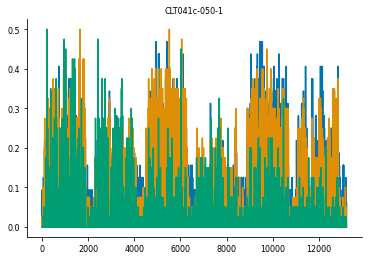

In [11]:
cids=[18,19,20]
cellids = [ctx['est']['resp'].chans[c] for c in cids]
Y_mono=Y_est_mono[:,:,cids]
Y_bin=Y_est_bin[:,:,cids]

plt.figure()
plt.plot(Y_val[:,cids]);
plt.title(cellids[0]);

In [12]:
input_channels = X_est_mono.shape[2]
time_lags = 16
rank = 7
strf_base = LN.LN_pop(time_lags, input_channels, len(cids), rank=rank, gaussian=False, fs=rec['resp'].fs)
strf_bin = strf_base.fit_LBHB(X_est_bin, Y_bin)
strf_mono = strf_base.fit_LBHB(X_est_mono, Y_mono)


[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 2200, 36)]        0         
[nems.backends.tf.backend INFO]  WeightChannels (WeightChann  (None, 2200, 1, 7)       252       
[nems.backends.tf.backend INFO]  elsTF)                                                          
[nems.backends.tf.backend INFO]  FiniteImpulseResponse (Fini  (None, 2200, 7)          112       
[nems.backends.tf.backend INFO]  teImpulseResponseTF)                                            
[nems.backends.tf.backend INFO]  WeightChannels0 (WeightChan  (None, 2200, 3)          21        
[nem

3/3 [==============================] - 0s 8ms/step - loss: 1.3364


[nems.backends.tf.backend INFO] Init loss: 1.336, tol: 0.001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/3000 - loss: 1.2908
[nems.backends.tf.backend INFO] Epoch 0050/3000 - loss: 0.8513
[nems.backends.tf.backend INFO] Epoch 0100/3000 - loss: 0.8489
[nems.backends.tf.backend INFO] Epoch 0150/3000 - loss: 0.8484
[nems.backends.tf.backend INFO] Epoch 0200/3000 - loss: 0.8481
[nems.backends.tf.backend INFO] Epoch 0250/3000 - loss: 0.8480
[nems.backends.tf.backend INFO] Final loss: 0.8480
[nems.models.LN INFO] Fit stage 2: with static output nonlinearity


Restoring model weights from the end of the best epoch: 102.
Epoch 00252: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[nems.backends.tf.backend INFO] Init loss: 1.114, tol: 0.0001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/8000 - loss: 1.1054
[nems.backends.tf.backend INFO] Epoch 0050/8000 - loss: 0.8533
[nems.backends.tf.backend INFO] Epoch 0100/8000 - loss: 0.8496
[nems.backends.tf.backend INFO] Epoch 0150/8000 - loss: 0.8483
[nems.backends.tf.backend INFO] Epoch 0200/8000 - loss: 0.8477
[nems.backends.tf.backend INFO] Epoch 0250/8000 - loss: 0.8473
[nems.backends.tf.backend INFO] Epoch 0300/8000 - loss: 0.8470
[nems.backends.tf.backend INFO] Epoch 0350/8000 - loss: 0.8467
[nems.backends.tf.backend INFO] Epoch 0400/8000 - loss: 0.8464
[nems.backends.tf.backend INFO] Epoch 0450/8000 - loss: 0.8462
[nems.backends.tf.backend INFO] Epoch 0500/8000 - los

Restoring model weights from the end of the best epoch: 1195.
Epoch 01345: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 2200, 36)]        0         
[nems.backends.tf.backend INFO]  WeightChannels (WeightChann  (None, 2200, 1, 7)       252       
[nems.backends.tf.backend INFO]  elsTF)                                                          
[nems.backends.tf.backend INFO]  FiniteImpulseResponse (Fini  (None, 2200, 7)          112       
[nems.backends.tf.backend INFO]  teImpulseResponseTF)                                            
[nems.backends.tf.backend INFO]  WeightChannels0 (WeightChan  (None, 2200, 3)          21        
[nem

3/3 [==============================] - 0s 6ms/step - loss: 1.3680


[nems.backends.tf.backend INFO] Init loss: 1.368, tol: 0.001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/3000 - loss: 1.3179
[nems.backends.tf.backend INFO] Epoch 0050/3000 - loss: 0.8733
[nems.backends.tf.backend INFO] Epoch 0100/3000 - loss: 0.8736
[nems.backends.tf.backend INFO] Epoch 0150/3000 - loss: 0.8714
[nems.backends.tf.backend INFO] Epoch 0200/3000 - loss: 0.8741
[nems.backends.tf.backend INFO] Epoch 0250/3000 - loss: 0.8710
[nems.backends.tf.backend INFO] Epoch 0300/3000 - loss: 0.8712
[nems.backends.tf.backend INFO] Epoch 0350/3000 - loss: 0.8715
[nems.backends.tf.backend INFO] Final loss: 0.8709
[nems.models.LN INFO] Fit stage 2: with static output nonlinearity


Restoring model weights from the end of the best epoch: 214.
Epoch 00364: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[tensorflow WARNING] 5 out of the last 16 calls to <function Model.make_test_function.<locals>.test_function at 0x7f5024691790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[nems.backends.tf.backend INFO] Init loss: 1.1

Restoring model weights from the end of the best epoch: 2558.
Epoch 02708: early stopping


In [13]:
pred_mono = strf_mono.predict(X_val)
pred_bin = strf_bin.predict(X_val)
pred_mono.shape, pred_bin.shape
r_bin = [np.corrcoef(pred_bin[:,i],Y_val[:,cid])[0,1] for i,cid in enumerate(cids)]
r_mono = [np.corrcoef(pred_mono[:,i],Y_val[:,cid])[0,1] for i,cid in enumerate(cids)]
#r_bins = [np.corrcoef(pred_bin[t1:(t1+2000),0],Y_val[t1:(t1+2000),cid])[0,1] for t1 in range(0,pred_mono.shape[0],2200)]
#r_monos = [np.corrcoef(pred_mono[t1:(t1+2000),0],Y_val[t1:(t1+2000),cid])[0,1] for t1 in range(0,pred_mono.shape[0],2200)]
r_bin,r_mono

([0.4993233480118551, 0.5818768001990383, 0.2608594937525169],
 [0.5416798344065368, 0.588311828171383, 0.2684067292372541])

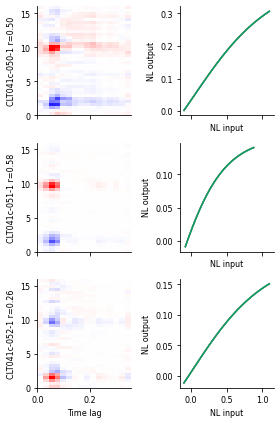

In [14]:
labels=[f"{c} r={r:.2f}" for c,r in zip(cellids, r_bin)]
strf_bin.plot_strf(labels=labels)

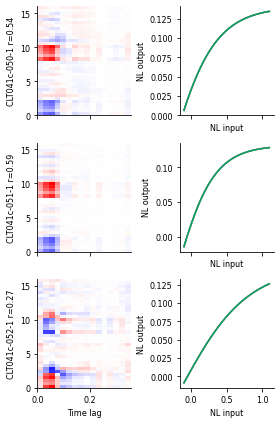

In [18]:
labels=[f"{c} r={r:.2f}" for c,r in zip(cellids, r_mono)]
strf_mono.plot_strf(labels=labels)

pick a cell and plot the test data PSTH to convince yourself it has a strong auditory response

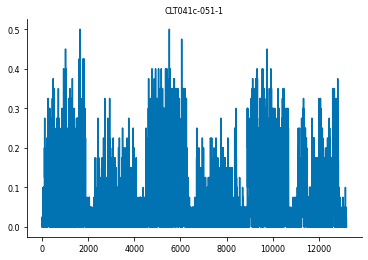

In [66]:
# pick a cell
cid=19
cellid = ctx['est']['resp'].chans[cid]
Y_mono=Y_est_mono[:,:,[cid]]
Y_bin=Y_est_bin[:,:,[cid]]

plt.figure()
plt.plot(Y_val[:,cid]);
plt.title(cellid);

Fit STRF single sound STRF

In [72]:
input_channels = X_est_mono.shape[2]
time_lags = 16
rank = 5
strf_base = LN.LN_STRF(time_lags, input_channels, rank=rank, gaussian=False)
strf_bin = strf_base.fit_LBHB(X_est_bin, Y_bin)
strf_mono = strf_base.fit_LBHB(X_est_mono, Y_mono)


[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 2200, 36)]        0         
[nems.backends.tf.backend INFO]  WeightChannels (WeightChann  (None, 2200, 5)          180       
[nems.backends.tf.backend INFO]  elsTF)                                                          
[nems.backends.tf.backend INFO]  FiniteImpulseResponse (Fini  (None, 2200, 1)          80        
[nems.backends.tf.backend INFO]  teImpulseResponseTF)                                            
[nems.backends.tf.backend INFO]  DoubleExponential (StaticNo  (None, 2200, 1)          4         
[nem

3/3 [==============================] - 0s 8ms/step - loss: 1.3008


[nems.backends.tf.backend INFO] Init loss: 1.301, tol: 0.001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/3000 - loss: 1.1307
[nems.backends.tf.backend INFO] Epoch 0050/3000 - loss: 0.8296
[nems.backends.tf.backend INFO] Epoch 0100/3000 - loss: 0.8286
[nems.backends.tf.backend INFO] Epoch 0150/3000 - loss: 0.8282
[nems.backends.tf.backend INFO] Epoch 0200/3000 - loss: 0.8280
[nems.backends.tf.backend INFO] Epoch 0250/3000 - loss: 0.8278
[nems.backends.tf.backend INFO] Final loss: 0.8278
[nems.models.LN INFO] Fit stage 2: with static output nonlinearity


Restoring model weights from the end of the best epoch: 102.
Epoch 00252: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[nems.backends.tf.backend INFO] Init loss: 1.736, tol: 0.0001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/8000 - loss: 1.7118
[nems.backends.tf.backend INFO] Epoch 0050/8000 - loss: 0.8440
[nems.backends.tf.backend INFO] Epoch 0100/8000 - loss: 0.8326
[nems.backends.tf.backend INFO] Epoch 0150/8000 - loss: 0.8301
[nems.backends.tf.backend INFO] Epoch 0200/8000 - loss: 0.8288
[nems.backends.tf.backend INFO] Epoch 0250/8000 - loss: 0.8281
[nems.backends.tf.backend INFO] Epoch 0300/8000 - loss: 0.8277
[nems.backends.tf.backend INFO] Epoch 0350/8000 - loss: 0.8275
[nems.backends.tf.backend INFO] Epoch 0400/8000 - loss: 0.8274
[nems.backends.tf.backend INFO] Epoch 0450/8000 - loss: 0.8272
[nems.backends.tf.backend INFO] Epoch 0500/8000 - los

Restoring model weights from the end of the best epoch: 2826.
Epoch 02976: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 2200, 36)]        0         
[nems.backends.tf.backend INFO]  WeightChannels (WeightChann  (None, 2200, 5)          180       
[nems.backends.tf.backend INFO]  elsTF)                                                          
[nems.backends.tf.backend INFO]  FiniteImpulseResponse (Fini  (None, 2200, 1)          80        
[nems.backends.tf.backend INFO]  teImpulseResponseTF)                                            
[nems.backends.tf.backend INFO]  DoubleExponential (StaticNo  (None, 2200, 1)          4         
[nem

3/3 [==============================] - 0s 6ms/step - loss: 1.3372


[nems.backends.tf.backend INFO] Init loss: 1.337, tol: 0.001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/3000 - loss: 1.2179
[nems.backends.tf.backend INFO] Epoch 0050/3000 - loss: 0.8628
[nems.backends.tf.backend INFO] Epoch 0100/3000 - loss: 0.8646
[nems.backends.tf.backend INFO] Epoch 0150/3000 - loss: 0.8627
[nems.backends.tf.backend INFO] Epoch 0200/3000 - loss: 0.8605
[nems.backends.tf.backend INFO] Epoch 0250/3000 - loss: 0.8602
[nems.backends.tf.backend INFO] Epoch 0300/3000 - loss: 0.8684
[nems.backends.tf.backend INFO] Final loss: 0.8602
[nems.models.LN INFO] Fit stage 2: with static output nonlinearity


Restoring model weights from the end of the best epoch: 197.
Epoch 00347: early stopping


[nems.backends.tf.backend INFO] TF model built. (verbose=0)
[nems.backends.tf.backend INFO] Starting tf.backend.fit...
[nems.backends.tf.backend INFO] Cost function: nmse
[nems.backends.tf.backend INFO] TF model compiled
[nems.backends.tf.backend INFO] Init loss: 1.991, tol: 0.0001, batch_size: None, shuffle: False
[nems.backends.tf.backend INFO] Epoch 0000/8000 - loss: 1.9671
[nems.backends.tf.backend INFO] Epoch 0050/8000 - loss: 0.8736
[nems.backends.tf.backend INFO] Epoch 0100/8000 - loss: 0.8619
[nems.backends.tf.backend INFO] Epoch 0150/8000 - loss: 0.8614
[nems.backends.tf.backend INFO] Epoch 0200/8000 - loss: 0.8610
[nems.backends.tf.backend INFO] Epoch 0250/8000 - loss: 0.8607
[nems.backends.tf.backend INFO] Epoch 0300/8000 - loss: 0.8605
[nems.backends.tf.backend INFO] Epoch 0350/8000 - loss: 0.8604
[nems.backends.tf.backend INFO] Epoch 0400/8000 - loss: 0.8603
[nems.backends.tf.backend INFO] Epoch 0450/8000 - loss: 0.8602
[nems.backends.tf.backend INFO] Epoch 0500/8000 - los

Restoring model weights from the end of the best epoch: 2818.
Epoch 02968: early stopping


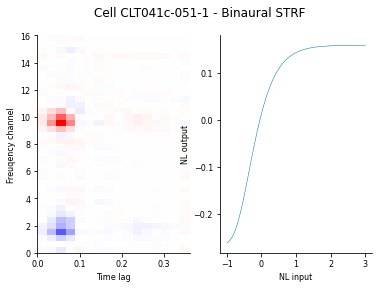

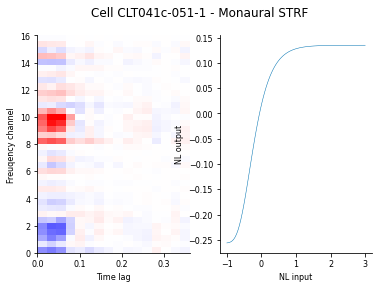

In [73]:
from nems.visualization.model import simple_strf

simple_strf(strf_bin, fs=100, title=f"Cell {cellid} - Binaural STRF")
simple_strf(strf_mono, fs=100, title=f"Cell {cellid} - Monaural STRF");

In [74]:
pred_mono = strf_mono.predict(X_val)
pred_bin = strf_bin.predict(X_val)
pred_mono.shape, pred_bin.shape
r_bin = np.corrcoef(pred_bin[:,0],Y_val[:,cid])[0,1]
r_mono = np.corrcoef(pred_mono[:,0],Y_val[:,cid])[0,1]
r_bins = [np.corrcoef(pred_bin[t1:(t1+2000),0],Y_val[t1:(t1+2000),cid])[0,1] for t1 in range(0,pred_mono.shape[0],2200)]
r_monos = [np.corrcoef(pred_mono[t1:(t1+2000),0],Y_val[t1:(t1+2000),cid])[0,1] for t1 in range(0,pred_mono.shape[0],2200)]
r_bins,r_monos

([0.528788947981659,
  0.2098987221657219,
  0.48746729707900455,
  0.1333699599468572,
  0.4805926305456552,
  0.5601865582617426],
 [0.483504301772674,
  0.22649352544573864,
  0.4765185175181061,
  0.22402366865777046,
  0.5248631414584457,
  0.5928297056898637])

r_mono: 0.592 r_binaural: 0.584


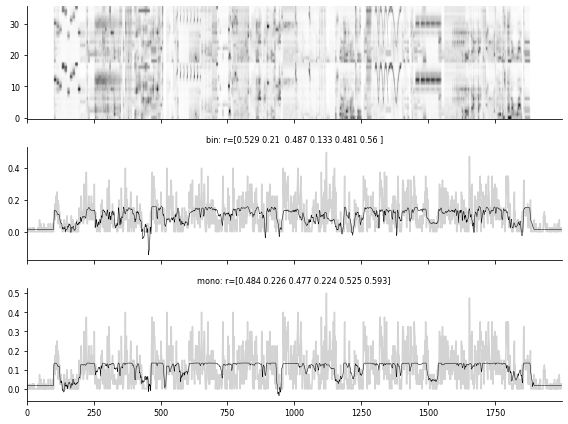

In [75]:
f,ax = plt.subplots(3,1,figsize=(8,6), sharex=True)

offset=2200*2
t1,t2=offset,offset+2000

ax[0].imshow(X_val[t1:t2,:].T, aspect='auto', cmap='gray_r', origin='lower')
ax[1].plot(Y_val[t1:t2,cid], color='lightgray')
ax[1].plot(pred_bin[t1:t2], color='black', lw=0.5)
ax[1].set_title(f"bin: r={np.round(r_bins,3)}")
ax[2].plot(Y_val[t1:t2,cid], color='lightgray')
ax[2].plot(pred_mono[t1:t2], color='black', lw=0.5)
ax[2].set_title(f"mono: r={np.round(r_monos,3)}")
plt.tight_layout()
print(f"r_mono: {r_mono:.3f} r_binaural: {r_bin:.3f}")

In [42]:
val_epochs = ep.epoch_names_matching(ctx['val']['resp'].epochs, "^STIM_")
val_epochs

['STIM_00seq4:1+00seq5_hand:2',
 'STIM_00seq4:1+NULL:2',
 'STIM_00seq5_hand:1+00seq4:2',
 'STIM_00seq5_hand:1+NULL:2',
 'STIM_NULL:1+00seq4:2',
 'STIM_NULL:1+00seq5_hand:2']